# Data processing

In [14]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
from pathlib import Path
import torch
import torch.optim as optim
import torch.nn as nn
import platform
from PIL import Image
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

from step_by_step import StepByStep
from models import Segnet
plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We have accumulated labels in the `data\all_labels` folder. We need to:
- load all of them into NCWH tensors
- split them into train and valid (test labels will be separate), 
- create temporary Datasets and normalizer
- create real Datasets and DataLoaders. 

## Generate tensors

Let's first create a `x_tensor/y_tensor` from all_labels:

In [295]:
proj_dir = Path('.').resolve().parent
data_dir = proj_dir / 'data'
train_imgs_dir = data_dir / 'all_labels/type_1/imgs'
train_masks_dir = data_dir / 'all_labels/type_1/masks'
image_paths = sorted(list(train_imgs_dir.glob('*.png')))
mask_paths = sorted(list(train_masks_dir.glob('*.png')))

In [296]:
len(image_paths)

162

Check there are no missing files:


In [297]:
a = set([x.name for x in image_paths])
b = set([x.name for x in mask_paths])
assert len(a ^ b) == 0

to go from a path to tensor use `torchvision.transforms.ToTensor()`:

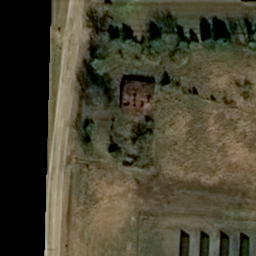

In [298]:
im = Image.open(image_paths[0])
im

To convert to tensor use `ToTensor()`:

In [299]:
image_tensor = ToTensor()(im)
image_tensor.shape

torch.Size([3, 256, 256])

For the mask, we convert to grayscale:

In [306]:
mask = Image.open(mask_paths[0])
mask_tensor = ToTensor()(mask.convert('L'))
mask_tensor = mask_tensor / mask_tensor.max()
print(mask_tensor.max())
mask_tensor.shape

tensor(1.)


torch.Size([1, 256, 256])

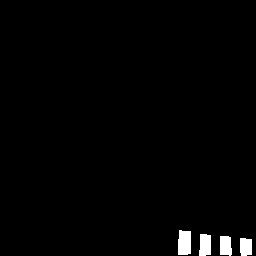

In [307]:
ToPILImage()(mask_tensor)

Let's combine these conversions and stack many images using `torch.stack` (not the most memory efficient way but it's ok):

In [308]:
tensorizer = ToTensor()
x_tensor = []
y_tensor = []

for image_path, mask_path in zip(image_paths, mask_paths):
    image_tensor = ToTensor()(Image.open(image_path))
    
    mask_tensor = ToTensor()(Image.open(mask_path).convert('L'))
    mask_tensor = mask_tensor / mask_tensor.max()
    
    x_tensor.append(image_tensor)
    y_tensor.append(mask_tensor)

x_tensor = torch.stack(x_tensor)
y_tensor = torch.stack(y_tensor)

In [309]:
print(x_tensor.shape)
print(y_tensor.shape)

torch.Size([162, 3, 256, 256])
torch.Size([162, 1, 256, 256])


## Split into train and valid

We'll use `torch.utils.data.random_split`:

In [310]:
torch.manual_seed(13)  # Important for consistency
N = len(x_tensor)
n_train = int(.8*N)
n_val = N - n_train
train_subset, val_subset = random_split(x_tensor, [n_train, n_val])

train_idx = train_subset.indices
val_idx = val_subset.indices

print(train_idx)
print(val_idx)

[22, 101, 76, 11, 44, 97, 18, 51, 86, 123, 125, 59, 0, 63, 92, 111, 114, 41, 95, 27, 67, 36, 110, 83, 62, 10, 127, 144, 69, 145, 143, 133, 117, 55, 58, 42, 89, 7, 94, 50, 38, 150, 70, 153, 137, 105, 155, 96, 1, 102, 138, 140, 93, 131, 4, 5, 141, 71, 21, 91, 35, 149, 124, 30, 151, 147, 85, 16, 160, 57, 32, 103, 115, 156, 74, 104, 77, 87, 6, 129, 80, 139, 60, 119, 75, 90, 61, 78, 46, 98, 134, 116, 128, 25, 154, 148, 108, 2, 15, 24, 79, 84, 135, 126, 107, 120, 37, 82, 52, 100, 68, 53, 54, 19, 118, 9, 132, 40, 31, 29, 146, 73, 161, 72, 152, 136, 48, 49, 8]
[99, 66, 157, 121, 12, 64, 142, 130, 3, 14, 106, 33, 23, 65, 112, 88, 39, 45, 56, 13, 122, 47, 159, 81, 17, 28, 20, 34, 113, 43, 158, 26, 109]


In [311]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

In [312]:
print(x_train_tensor.shape)
print(x_val_tensor.shape)

torch.Size([129, 3, 256, 256])
torch.Size([33, 3, 256, 256])


## Temporary Datasets

Our very simple dataset with transform:

In [313]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

Let's first create **temporary** `Dataset` to extract normalization parameters:

In [314]:
temp_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor)
temp_loader = DataLoader(temp_dataset, batch_size=32)
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.1902, 0.2077, 0.1599]), std=tensor([0.1060, 0.1060, 0.1071]))

## Real Datasets and Loaders

Let's now create **real** `Datasets` and `DataLoaders`:

In [315]:
train_composer = Compose([normalizer])  # train_composer will have augmentations later
val_composer = Compose([normalizer])

train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Training prep

Let's now define model, optimizer, and loss.

## Model

In [316]:
segnet = Segnet()

In [317]:
list(segnet.named_parameters())

[('down_1.model.0.weight',
  Parameter containing:
  tensor([[[[ 0.0346, -0.1124,  0.1062,  0.0474,  0.0889],
            [ 0.0273,  0.1142,  0.1124, -0.0117,  0.0929],
            [ 0.0282, -0.0908,  0.0546,  0.0270,  0.0637],
            [ 0.0265,  0.0070, -0.0677,  0.0416, -0.0305],
            [ 0.0389,  0.1113,  0.1043,  0.0215, -0.0102]],
  
           [[-0.0198,  0.0911,  0.0555, -0.0048,  0.1077],
            [ 0.0124,  0.1068, -0.0786, -0.0154,  0.1117],
            [ 0.1097,  0.0273, -0.0320, -0.0500,  0.0123],
            [ 0.0223, -0.0931,  0.0537,  0.0712,  0.1011],
            [-0.0018, -0.1080, -0.0235,  0.0024, -0.0323]],
  
           [[ 0.0932, -0.0474, -0.0074, -0.0875,  0.0042],
            [-0.0450, -0.0727,  0.0851,  0.0472, -0.0923],
            [-0.1084,  0.0718,  0.0252,  0.0117,  0.0530],
            [ 0.0096,  0.0704,  0.0366,  0.0733, -0.0863],
            [-0.1030, -0.0631,  0.0786,  0.0091,  0.1108]]],
  
  
          [[[ 0.0831,  0.0226,  0.0308,  0.0679,

In [318]:
x, y = next(iter(train_loader))
x

tensor([[[[-1.2029, -1.0919, -0.8699,  ...,  0.1663,  0.0923, -0.0557],
          [-1.2029, -1.1659, -0.9069,  ...,  0.2403,  0.0923, -0.0927],
          [-1.2029, -1.2399, -1.0179,  ...,  0.2774,  0.1293, -0.0187],
          ...,
          [ 1.9057,  1.8687,  1.3506,  ..., -1.3510, -0.9809,  0.1663],
          [ 2.0907,  1.9797,  1.3876,  ..., -1.3140, -0.8699,  0.3144],
          [ 2.0537,  1.9427,  1.2395,  ..., -1.3140, -0.7588,  0.3884]],

         [[-1.0719, -0.8868, -0.5537,  ...,  0.4456,  0.3345,  0.1495],
          [-1.0719, -0.9979, -0.6277,  ...,  0.4826,  0.2975,  0.1125],
          [-1.0719, -1.0719, -0.7758,  ...,  0.5566,  0.3715,  0.1865],
          ...,
          [ 1.6299,  1.6299,  1.1488,  ..., -1.2569, -0.8498,  0.5196],
          [ 1.8150,  1.7780,  1.1488,  ..., -1.1829, -0.7018,  0.6676],
          [ 1.7780,  1.7039,  0.9267,  ..., -1.2199, -0.5537,  0.7787]],

         [[-1.3463, -1.0169, -0.5044,  ...,  0.5572,  0.3742,  0.1911],
          [-1.3097, -1.1999, -

In [319]:
y[0].shape

torch.Size([1, 256, 256])

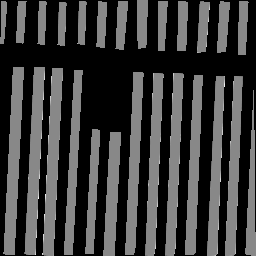

In [320]:
example_pil = ToPILImage()(y[0])
example_pil

In [321]:
y[0].max()

tensor(1.)

In [325]:
x.shape

torch.Size([32, 3, 256, 256])

In [327]:
segnet(x)

RuntimeError: Given groups=1, weight of size [64, 32, 5, 5], expected input[32, 64, 128, 128] to have 32 channels, but got 64 channels instead

# Appendix


In [157]:
a = torch.Tensor([1])
b = torch.Tensor([2])
c = torch.cat([a,b], dim=0)
print(c)

tensor([1., 2.])


In [ ]:
a = torch.Tensor([1])
b = torch.Tensor([2])
c = torch.cat([a,b], dim=0)
print(c)

In [158]:
a = torch.Tensor([1])
b = torch.Tensor([2])
c = torch.stack([a,b], dim=0)
d = torch.stack([a,b], dim=1)
print(c)
print(d)

tensor([[1.],
        [2.]])
tensor([[1., 2.]])


In [ ]:
""" Full assembly of the parts to form the complete network """

from .unet_parts import *


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)